# Adversarial Search: Playing Connect 4

Student Name: Ryan Sweeney

I have used the following AI tools: Torch

I understand that my submission needs to be my own work: RS

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your: implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation: results) with a: short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

SyntaxError: invalid syntax (2086168889.py, line 3)

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

In [ ]:
# Your code/answer goes here.

# initial State
The initial state is an empty board. The board is a 6x7 grid with all cells empty.

# Actions
For each player the set of actions is the player can drop a colored disc into one of the columns in the grid. The action is only valid if and only if the column is not full.

# Transition Model
Given a state and an action the transisition model would specify the result of that action in that state. It would update the game state by adding a colored disc of the players color in the lowest available row

# Goal State
The game reaches a terminal state in a couple case. If either colored chips align to form 4 in a row in any direction vertical horizontal or diagonal. The game is a draw if the board is full and no player has won. The utility function would return 1 if the player wins, -1 if the player loses and 0 if the game is a draw.

How big is the state space? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.


# State Space

The state space of the game is the number of possible board configurations. The game board is a 6x7 grid with each cell having 3 possible states. Empty, red and yellow. The total number of possible states is 3^42 which is 7.3 x 10^19. This is the total number of possible board configurations. The number of possible games is much smaller than this as the game can end in a draw or a win. The number of possible games is estimated to be around 4.5 x 10^12. This is calculated by the number of possible games that can be played before the board is full. The number of possible games is calculated by the number of possible moves in each turn. The number of possible moves in each turn is the number of columns in the grid. The number of possible moves in each turn is 7. The number of possible games is calculated by 7^42 which is 4.5 x 10^12. This is the number of possible games that can be played before the board is full

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [ ]:
# Your code/ answer goes here.

# Game Tree

The game tree is the number of possible states that can be reached from the initial state. The game tree has a branching factor of the number of possible moves each turn which is up to 7 depending on the state of the board. The depth of the game tree is the number of moves that can be played before the game reaches a terminal state.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

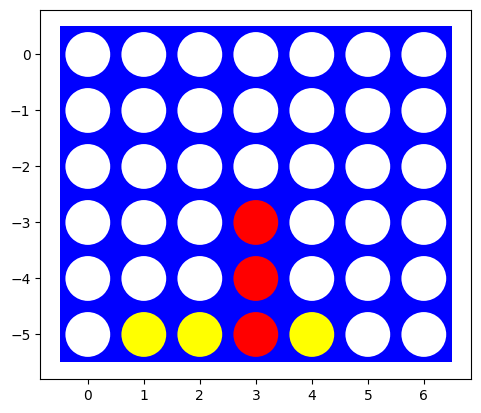

In [3]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [54]:
# Your code/ answer goes here.

import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

def actions(board):
    available_actions = []
    for col in range(board.shape[1]):
        if board[0][col] == 0:  # If the top row of the column is empty
            available_actions.append(col)
    return available_actions

def result(board, action, player):
    new_board = board.copy()
    for row in range(new_board.shape[0]-1, -1, -1):
        if new_board[row][action] == 0:
            new_board[row][action] = player
            break
    return new_board

def terminal(board):
    # Check for a win
    for player in [-1, 1]:
        # Check horizontal
        for row in range(board.shape[0]):
            for col in range(board.shape[1] - 3):  # make sure the board's width is considered
                if all(board[row][col+i] == 1 for i in range(4)):
                    return True, 1
                if all(board[row][col+i] == -1 for i in range(4)):
                    return True, -1

        # Check vertical
        for col in range(board.shape[1]):
            for row in range(board.shape[0] - 3):
                if all(board[row+i][col] == player for i in range(4)):
                    return True, player

        # Check diagonals
        for row in range(board.shape[0] - 3):
            for col in range(board.shape[1] - 3):
                if all(board[row+i][col+i] == player for i in range(4)):
                    return True, player
                if all(board[row+i][col+3-i] == player for i in range(4)):
                    return True, player

    # Check for a draw
    if np.all(board != 0):
        return True, 0

    return False, None

def utility(board):
    terminal_state, winner = terminal(board)
    if terminal_state:
        if winner == 1:
            return 1000  # Large positive value for a win
        elif winner == -1:
            return -1000  # Large negative value for a loss
        else:
            return 0  # Neutral value for a draw
    else:
        return 0


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [11]:
# Your code/ answer goes here.

import numpy as np

def random_player(board, player=1):
    available_actions = actions(board)
    return np.random.choice(available_actions)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [12]:
# Your code/ answer goes here.

# Define the environment to play Connect 4
def connect4_env(player1, player2, num_games=1000):
    player1_wins = 0
    player2_wins = 0
    draws = 0

    for _ in range(num_games):
        board = empty_board()
        current_player = 1

        while True:
            # Player 1's turn
            if current_player == 1:
                action = player1(board, player=1)
                board = result(board, action, player=1)
                terminal_state, winner = terminal(board)
                if terminal_state:
                    if winner == 1:
                        player1_wins += 1
                    elif winner == -1:
                        player2_wins += 1
                    else:
                        draws += 1
                    break

            # Player 2's turn
            else:
                action = player2(board, player=-1)
                board = result(board, action, player=-1)
                terminal_state, winner = terminal(board)
                if terminal_state:
                    if winner == 1:
                        player1_wins += 1
                    elif winner == -1:
                        player2_wins += 1
                    else:
                        draws += 1
                    break

            # Switch players
            current_player *= -1

    return player1_wins, player2_wins, draws

# Let two random agents play against each other 1000 times
player1_wins, player2_wins, draws = connect4_env(random_player, random_player, num_games=1000)

print("Player 1 wins:", player1_wins)
print("Player 2 wins:", player2_wins)
print("Draws:", draws)


Player 1 wins: 546
Player 2 wins: 451
Draws: 3


# results from random agent

Player 1 wins: 551
Player 2 wins: 443
Draws: 6

This result was slightly unexpected at first because I expected way more draws, but then when I thought about it it is a lot harder to arange the full board with no 4 in a rows, than it is to have 1 4 in a row somewhere so it is expected to get about even wins for each player. with a slight edge to player 1, and a very small amount of draws.

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [31]:
# Your code/ answer goes here.

class MinimaxABAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def minimax(self, board, depth, alpha, beta, maximizingPlayer):
        terminal_state, winner = terminal(board)
        if depth == 0 or terminal_state:
            return utility(board), None

        if maximizingPlayer:
            max_eval = -float('inf')
            best_action = None
            for action in actions(board):
                result_board = result(board, action, 1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action
        else:
            min_eval = float('inf')
            best_action = None
            for action in actions(board):
                result_board = result(board, action, -1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action

    def choose_action(self, board, player=1):
        _, action = self.minimax(board, self.depth, -float('inf'), float('inf'), player == 1)
        return action



Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [59]:
# Your code/ answer goes here.

import numpy as np

# Initialize the agent
agent = MinimaxABAgent()

# Define test boards
boards = {
    "Immediate Horizontal Win": np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0]
    ]),
    "Immediate Vertical Win": np.array([
        [0, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, -1, -1, -1]
    ]),
    "Immediate Diagonal Win": np.array([
        [0, 0, 0, 0],
        [0, 0, 1, -1],
        [0, 1, -1, 1],
        [1, -1, 1, -1]
    ]),
    "Block Opponent's Win": np.array([
        [0, 0, 0, 0],
        [0, -1, 0, 0],
        [1, -1, 0, 0],
        [1, -1, 1, 0]
    ]),
    "Complex Board with Winning Opportunity": np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, -1, 1],
        [0, -1, 1, -1]
    ])
}

import time

# Test the agent on each board
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")



Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.0039958953857421875 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.005999326705932617 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.003000020980834961 seconds
Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.003000497817993164 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 2. Time taken: 0.0029997825622558594 seconds


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

#Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.0059969425201416016 seconds
#Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.0020017623901367188 seconds
#Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.004998207092285156 seconds
#Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.002999544143676758 seconds
#Complex Board with Winning Opportunity: Best action for Player 1 is column 0. Time taken: 0.0030031204223632812 seconds

Even with just a small board the agent takes a long time to make a move if there is not a max depth set. This is because the search space is so large. The agent has to search through all possible moves to find the best one. This is why the agent takes so long to make a move. The time it takes to make a move increases exponentially as the size of the board increases.

### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [34]:
# Your code/ answer goes here.
def actions(board):
    columns = range(board.shape[1])
    # Order columns by closeness to the center
    sorted_columns = sorted(columns, key=lambda x: abs(x - board.shape[1] // 2))
    available_actions = []
    for col in sorted_columns:
        if board[0][col] == 0:  # If the top row of the column is empty
            available_actions.append(col)
    return available_actions


class MinimaxABAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def actions(self, board):
        columns = range(board.shape[1])
        # Order columns by closeness to the center
        sorted_columns = sorted(columns, key=lambda x: abs(x - board.shape[1] // 2))
        available_actions = []
        for col in sorted_columns:
            if board[0][col] == 0:  # If the top row of the column is empty
                available_actions.append(col)
        return available_actions

    def minimax(self, board, depth, alpha, beta, maximizingPlayer):
        terminal_state, winner = terminal(board)
        if depth == 0 or terminal_state:
            return utility(board), None

        if maximizingPlayer:
            max_eval = -float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, 1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action
        else:
            min_eval = float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, -1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action

    def choose_action(self, board, player=1):
        _, action = self.minimax(board, self.depth, -float('inf'), float('inf'), player == 1)
        return action

# Test the agent on each board
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")

Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.0039980411529541016 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.0060007572174072266 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.002003192901611328 seconds
Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.003999233245849609 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 2. Time taken: 0.0030012130737304688 seconds


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

We can implement a simple symmetry opening strategy, because this should play decently and allow us to get past the beginning of the game faster.

In [61]:
class MinimaxOpeningAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def symmetric_move(self, last_move, board_width):
        return board_width - last_move - 1

    def evaluate_asymmetry(self, board):
        mid = board.shape[1] // 2
        left_weight = sum(board[:, :mid].flat)
        right_weight = sum(board[:, mid+1:].flat)
        return left_weight, right_weight

    def balance_moves(self, left_weight, right_weight, sorted_columns):
        if left_weight > right_weight:
            return sorted(sorted_columns, key=lambda x: x)
        else:
            return sorted(sorted_columns, key=lambda x: -x)

    def actions(self, board, last_move=None):
        if np.all(board == 0):
            return [board.shape[1] // 2]  # Center start

        if last_move is not None:
            sym_move = self.symmetric_move(last_move, board.shape[1])
            if board[0][sym_move] == 0:
                return [sym_move]

        columns = range(board.shape[1])
        sorted_columns = sorted(columns, key=lambda x: abs(x - board.shape[1] // 2))
        left_weight, right_weight = self.evaluate_asymmetry(board)
        balanced_columns = self.balance_moves(left_weight, right_weight, sorted_columns)

        available_actions = []
        for col in balanced_columns:
            if board[0][col] == 0:
                available_actions.append(col)
        return available_actions

    def minimax(self, board, depth, alpha, beta, maximizingPlayer):
        terminal_state, winner = terminal(board)
        if depth == 0 or terminal_state:
            return utility(board), None

        if maximizingPlayer:
            max_eval = -float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, 1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action
        else:
            min_eval = float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, -1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action

    def choose_action(self, board, player=1):
        _, action = self.minimax(board, self.depth, -float('inf'), float('inf'), player == 1)
        return action

# Test the agent on each board
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")

Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.0059986114501953125 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.002001047134399414 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.004998922348022461 seconds
Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.0060007572174072266 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 3. Time taken: 0.0039997100830078125 seconds


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [56]:
# Your code/ answer goes here.

def play_game(player1, player2):
    board = empty_board(shape=(4, 4))
    current_player = 1

    while True:
        action = player1(board, player=current_player) if current_player == 1 else player2(board, player=current_player)
        board = result(board, action, current_player)
        terminal_state, winner = terminal(board)
        if terminal_state:
            return winner
        current_player *= -1

def simulate_games(num_games):
    minimax_agent = MinimaxOpeningAgent()
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        winner = play_game(minimax_agent.choose_action, random_player)
        if winner == 1:
            wins += 1
        elif winner == -1:
            losses += 1
        else:
            draws += 1

    return wins, losses, draws

# Example usage
wins, losses, draws = simulate_games(100)
print(f"Minimax wins: {wins}, Losses: {losses}, Draws: {draws}")


Minimax wins: 57, Losses: 1, Draws: 42


# Full size board
Minimax wins: 100, Losses: 0, Draws: 0
# 4x4 board
Minimax wins: 54, Losses: 12, Draws: 34

The minimax agent was pretty effective against the random agent

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [62]:
# Your code/ answer goes here.

def heuristic(board, player):
    """ Evaluate board state for the given player (1 or -1) """
    opponent = -player
    scores = {player: 0, opponent: 0}

    # Potential lines to consider: horizontal, vertical, and two diagonals
    lines = []
    for i in range(4):
        lines.append(board[i, :])  # Horizontal
        lines.append(board[:, i])  # Vertical

    lines.append(np.array([board[i, i] for i in range(4)]))  # Main diagonal
    lines.append(np.array([board[i, 3-i] for i in range(4)]))  # Anti-diagonal

    # Scoring system
    for line in lines:
        if np.count_nonzero(line == player) == 3 and np.count_nonzero(line == 0) == 1:
            scores[player] += 5  # Three in a line with an open slot
        elif np.count_nonzero(line == player) == 2 and np.count_nonzero(line == 0) == 2:
            scores[player] += 2  # Two in a line with two open slots

        if np.count_nonzero(line == opponent) == 3 and np.count_nonzero(line == 0) == 1:
            scores[opponent] += 5  # Three in a line against player
        elif np.count_nonzero(line == opponent) == 2 and np.count_nonzero(line == 0) == 2:
            scores[opponent] += 2  # Two in a line against player

    # Center control (more valuable for potential connections)
    center_column = board[:, 2]
    center_count = np.count_nonzero(center_column == player)
    scores[player] += center_count * 3

    # Calculate net heuristic value
    heuristic_value = scores[player] - scores[opponent]
    return heuristic_value

def utility(board):
    terminal_state, winner = terminal(board)
    if terminal_state:
        if winner == 1:
            return 1000  # Minimax wins
        elif winner == -1:
            return -1000  # Random wins
        else:
            return 0  # Draw
    else:
        # Use heuristic function for non-terminal states
        return heuristic(board, 1)


In [43]:
class HeuristicMinimaxOpeningAgent:
    def __init__(self, depth=4):
        self.depth = depth

    def actions(self, board):
        # If the board is empty, prefer the center column
        if np.all(board == 0):
            return [board.shape[1] // 2]  # Always start in the center column if possible
        columns = range(board.shape[1])
        sorted_columns = sorted(columns, key=lambda x: abs(x - board.shape[1] // 2))
        available_actions = []
        for col in sorted_columns:
            if board[0][col] == 0:
                available_actions.append(col)
        return available_actions

    def minimax(self, board, depth, alpha, beta, maximizingPlayer):
        terminal_state, winner = terminal(board)
        if depth == 0 or terminal_state:
            return utility(board), None

        if maximizingPlayer:
            max_eval = -float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, 1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_action = action
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action
        else:
            min_eval = float('inf')
            best_action = None
            for action in self.actions(board):
                result_board = result(board, action, -1)
                eval, _ = self.minimax(result_board, depth - 1, alpha, beta, True)
                if eval < min_eval:
                    min_eval = eval
                    best_action = action
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action


    def choose_action(self, board, player=1):
        _, action = self.minimax(board, self.depth, -float('inf'), float('inf'), player == 1)
        return action

# Test the agent on each board
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")



Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.009999513626098633 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.01300048828125 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.003996610641479492 seconds
Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.008001089096069336 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 2. Time taken: 0.007004976272583008 seconds


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [41]:
# Your code/ answer goes here.
#I already implemented this earlier on in the lab the specified depth value allows you to limit how deep the tree is explored.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [44]:
# Your code/ answer goes here.

# Test the agent on each board
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")

Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 0.007999181747436523 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 0.012999773025512695 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.004001140594482422 seconds
Block Opponent's Win: Best action for Player 1 is column 1. Time taken: 0.00800013542175293 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 2. Time taken: 0.005999326705932617 seconds


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [75]:
def empty_board(size):
    return np.zeros((size, size), dtype=int)

def actions(board):
    return [col for col in range(board.shape[1]) if board[0][col] == 0]

def result(board, action, player):
    new_board = board.copy()
    for row in reversed(range(board.shape[0])):
        if new_board[row][action] == 0:
            new_board[row][action] = player
            break
    return new_board

def terminal(board):
    n = board.shape[0]
    # Check rows, columns and diagonals
    for i in range(n):
        for j in range(n - 3):
            # Horizontal
            if np.all(board[i, j:j+4] == board[i, j]) and board[i, j] != 0:
                return True, board[i, j]
            # Vertical
            if np.all(board[j:j+4, i] == board[j, i]) and board[j, i] != 0:
                return True, board[j, i]

    # Diagonals
    for i in range(n - 3):
        for j in range(n - 3):
            if np.all([board[i+k, j+k] == board[i, j] for k in range(4)]) and board[i, j] != 0:
                return True, board[i, j]
            if np.all([board[i+3-k, j+k] == board[i+3, j] for k in range(4)]) and board[i+3, j] != 0:
                return True, board[i+3, j]

    if np.all(board != 0):
        return True, 0

    return False, None

def heuristic(board, player):
    opponent = -player
    scores = {player: 0, opponent: 0}
    lines = []
    n = board.shape[0]
    for i in range(n):
        lines.append(board[i, :])  # Horizontal
        lines.append(board[:, i])  # Vertical

    lines.append(np.diag(board))  # Main diagonal
    lines.append(np.diag(np.fliplr(board)))  # Anti-diagonal

    for line in lines:
        for p in [player, opponent]:
            for count in [2, 3]:
                if np.count_nonzero(line == p) == count and np.count_nonzero(line == 0) == 4 - count:
                    scores[p] += count

    return scores[player] - scores[opponent]

def utility(board):
    term, winner = terminal(board)
    if term:
        if winner == 1 or winner == -1:
            return winner * 1000
        else:
            return 0
    else:
        return heuristic(board, 1)

Time for 4x4 board: 0.12 seconds
Time for 5x5 board: 0.79 seconds
Time for 6x6 board: 1.06 seconds
Time for 7x7 board: 2.95 seconds
Time for 8x8 board: 9.01 seconds


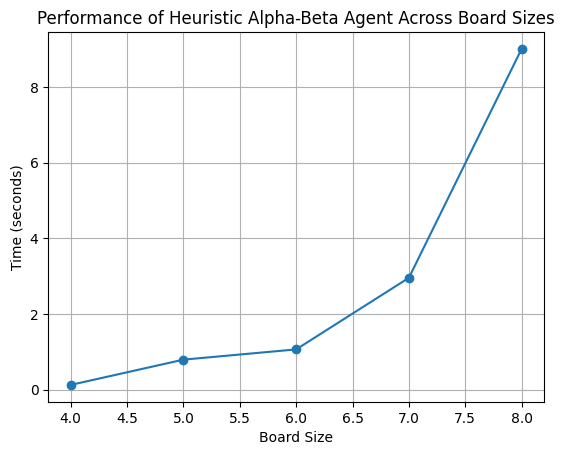

In [51]:
# Your code/ answer goes here.
def simulate_game(board_size):
    board = empty_board(board_size)
    player = 1
    start_time = time.time()

    while True:
        action = agent.choose_action(board, player)
        board = result(board, action, player)
        term, winner = terminal(board)
        if term:
            break
        player *= -1

    return time.time() - start_time

# Collect data across different board sizes
times = []
sizes = range(4, 9)  # From 4x4 to 8x8
for size in sizes:
    t = simulate_game(size)
    times.append(t)
    print(f"Time for {size}x{size} board: {t:.2f} seconds")

# Plotting the results
plt.plot(sizes, times, marker='o')
plt.xlabel('Board Size')
plt.ylabel('Time (seconds)')
plt.title('Performance of Heuristic Alpha-Beta Agent Across Board Sizes')
plt.grid(True)
plt.show()


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [71]:
class HeuristicMinimaxOpeningAgent:
    def __init__(self, depth):
        self.depth = depth

    def minimax(self, board, depth, alpha, beta, player):
        terminal_state, winner = terminal(board)
        if depth == 0 or terminal_state:
            return utility(board), None

        best_value = float('-inf') if player == 1 else float('inf')
        best_action = None
        for action in actions(board):
            new_board = result(board, action, player)
            eval, _ = self.minimax(new_board, depth - 1, alpha, beta, -player)
            if player == 1:  # Maximizing player
                if eval > best_value:
                    best_value = eval
                    best_action = action
                alpha = max(alpha, eval)
            else:  # Minimizing player
                if eval < best_value:
                    best_value = eval
                    best_action = action
                beta = min(beta, eval)
            if beta <= alpha:
                break
        return best_value, best_action

    def choose_action(self, board, player):
        _, action = self.minimax(board, self.depth, float('-inf'), float('inf'), player)
        return action




Board size 4x4: Winner is Draw
Board size 5x5: Winner is Player 2
Board size 6x6: Winner is Draw
Board size 7x7: Winner is Draw
Board size 8x8: Winner is Player 2
Board size 9x9: Winner is Player 2


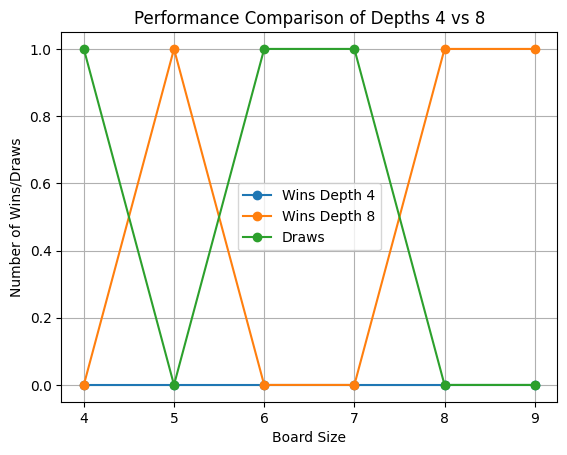

In [72]:
# Your code/ answer goes here.
def play_game(board_size, depth1, depth2):
    board = empty_board(board_size)
    agent1 = HeuristicMinimaxOpeningAgent(depth1)
    agent2 = HeuristicMinimaxOpeningAgent(depth2)
    current_player = 1  # Player 1 starts

    while True:
        if current_player == 1:
            action = agent1.choose_action(board, current_player)
        else:
            action = agent2.choose_action(board, current_player)

        board = result(board, action, current_player)
        terminal_state, winner = terminal(board)
        if terminal_state:
            return winner
        current_player *= -1

def simulate_games(board_sizes, depth1, depth2):
    results = {size: [] for size in board_sizes}
    for size in board_sizes:
        winner = play_game(size, depth1, depth2)
        results[size].append(winner)
        print(f"Board size {size}x{size}: Winner is {'Player 1' if winner == 1 else 'Player 2' if winner == -1 else 'Draw'}")
    return results

import matplotlib.pyplot as plt

def plot_results(results):
    win_depth4 = []
    win_depth8 = []
    draws = []
    sizes = sorted(results.keys())
    for size in sizes:
        wins4 = sum(1 for result in results[size] if result == 1)
        wins8 = sum(1 for result in results[size] if result == -1)
        draw = sum(1 for result in results[size] if result == 0)
        win_depth4.append(wins4)
        win_depth8.append(wins8)
        draws.append(draw)

    plt.plot(sizes, win_depth4, label='Wins Depth 4', marker='o')
    plt.plot(sizes, win_depth8, label='Wins Depth 8', marker='o')
    plt.plot(sizes, draws, label='Draws', marker='o')
    plt.xlabel('Board Size')
    plt.ylabel('Number of Wins/Draws')
    plt.title('Performance Comparison of Depths 4 vs 8')
    plt.legend()
    plt.grid(True)
    plt.show()

# Running the simulation and plotting
board_sizes = range(4, 10)  # From 4x4 to 9x9
results = simulate_games(board_sizes, 4, 8)
plot_results(results)


# Results
Overall both were very close when challenging each other, but the extra 4 depth that player 2 had allowed it to win at some board sizes over player1.

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [79]:
import random


# Your code/ answer goes here.
class MonteCarloAgent:
    def __init__(self, num_simulations):
        self.num_simulations = num_simulations

    def simulate_game(self, board, start_player):
        current_player = start_player
        current_board = board.copy()
        while True:
            terminal_state, winner = terminal(current_board)  # Renamed variable here
            if terminal_state:
                return winner
            possible_actions = actions(current_board)
            if not possible_actions:
                return None  # Draw
            action = random.choice(possible_actions)
            current_board = result(current_board, action, current_player)
            current_player = -current_player  # Switch players

    def monte_carlo_search(self, board, player=1):
        action_list = actions(board)
        win_counts = {action: 0 for action in action_list}

        for action in action_list:
            for _ in range(self.num_simulations):
                new_board = result(board, action, player)
                winner = self.simulate_game(new_board, -player)
                if winner == player:
                    win_counts[action] += 1

        best_action = max(win_counts, key=win_counts.get)
        return best_action, win_counts[best_action] / self.num_simulations

    def choose_action(self, board, player=1):
        best_action, _ = self.monte_carlo_search(board, player)
        return best_action


# Test the agent on each board
agent = MonteCarloAgent(num_simulations=1000)
for description, board in boards.items():
    start_time = time.time()  # Record the start time
    action = agent.choose_action(board, player=1)
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{description}: Best action for Player 1 is column {action}. Time taken: {elapsed_time} seconds")

Immediate Horizontal Win: Best action for Player 1 is column 3. Time taken: 1.7039861679077148 seconds
Immediate Vertical Win: Best action for Player 1 is column 0. Time taken: 1.1242141723632812 seconds
Immediate Diagonal Win: Best action for Player 1 is column 3. Time taken: 0.9984095096588135 seconds
Block Opponent's Win: Best action for Player 1 is column 0. Time taken: 1.4553134441375732 seconds
Complex Board with Winning Opportunity: Best action for Player 1 is column 2. Time taken: 2.323323965072632 seconds


### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [80]:
# Your code/ answer goes here.
board_size = 6  #
board = empty_board(board_size)  # Creates an empty board
agent = MonteCarloAgent(num_simulations=1000)  # More simulations for more accuracy
best_first_move, win_rate = agent.monte_carlo_search(board, player=1)
print(f"Best first move: Column {best_first_move}, with an estimated win rate of {win_rate:.2f}")


Best first move: Column 2, with an estimated win rate of 0.60


In [ ]:
# we assume random opposition play. Our simulation resulted in a best first move of column 2 which is expected because middle columns are more powerful in the game. By doing many simulations we get a statistically significant result for what move would be good to do.